# **ALPIDE**: analysis of scattering profile

<span style="color:gold">
    <font size="6">
        <b>gold</b>
    </font>
</span>

## Preliminary operations

### Load packages

In [1]:
import os
import sys
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import multiprocessing

Welcome to JupyROOT 6.22/06


In [2]:
from pathlib import Path
from scipy.optimize import curve_fit

### Flags

In [3]:
ROOT.disableJSVis()

### Settings

In [4]:
N_cpu     = multiprocessing.cpu_count()
N_Threads = "%d" % (N_cpu-2)

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

### Functions

In [6]:
def make_histo(Data_array,Title,nbins,xmin,xmax,save=False):
    Histo = ROOT.TH1F(Title, Title, nbins, xmin, xmax)
    for value in Data_array:
        Histo.Fill(value)

    Canv = ROOT.TCanvas()
    Histo.Draw()
    
    if save:
        Image_name = Title + '_Histo.pdf'
        Canv.Print(Image_name)
    
    return Histo, Canv

In [7]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

## Geometry

### Center, width and height

In [8]:
px_center       = 547      # pixels
py_center       = 251      # pixels

In [9]:
ALPIDE_center   = -17      # steps
ALPIDE_distance = 78.63    # mm
ALPIDE_width    = 30       # mm
ALPIDE_height   = 13.8     # mm

### Min and max angular positions explored

In [10]:
th_max = 1.41
th_min = -1.41
thbins = 300

### Cuts on the matrix of pixels

In [11]:
ymin = 10
ymax = 490
xmin = 10
xmax = 1013

## Analysis on a specific dataset

In [12]:
DATA_PATH = "Data"
DATA_NAME = "center_alpide"

### Exposition times

In [13]:
ETHist = ROOT.TH1F('ETHist', 'Exposition time', thbins, th_min, th_max)
files  = os.listdir(DATA_PATH + "/")

with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        pbar.update(1)
        
        if name.startswith(DATA_NAME):
            angle = int(name.split('_')[2]) * (1 if name.split('_')[3]=='DC' else -1)
            file  = open(DATA_PATH+"/"+name+"/Stat_"+name+".txt")
            line  = file.readlines()

            for l in line:
                if (l.startswith("Readout_time")):
                    time   = float(l.split('=')[1].strip()[:-1])
                if (l.startswith("Strobe")):
                    Strobe = int(l.split('=')[1].strip()[:-1])
                if (l.startswith("Gap")):
                    Gap    = int(l.split('=')[1].strip()[:-1])

            exp_time = (Strobe * time) / (Gap + Strobe)

            
            x  = np.arange(xmin,xmax, step=1)
            y  = np.arange(ymin,ymax, step=1)
            xd = (x - px_center) * ALPIDE_width / 1024
            yd = np.sqrt(((y - py_center) * ALPIDE_height / 512)**2 + (ALPIDE_distance)**2)

            #take all combinations of xd and yd
            pixels = np.array(np.meshgrid(xd, yd)).T.reshape(-1, 2) 
            Thetas = np.arctan2(pixels[:,0],pixels[:,1])+(angle+ALPIDE_center)*0.9*np.pi/180
            
            for Theta in Thetas:
                ETHist.Fill(Theta,exp_time)

100%|██████████| 374/374 [00:35<00:00, 10.48it/s]


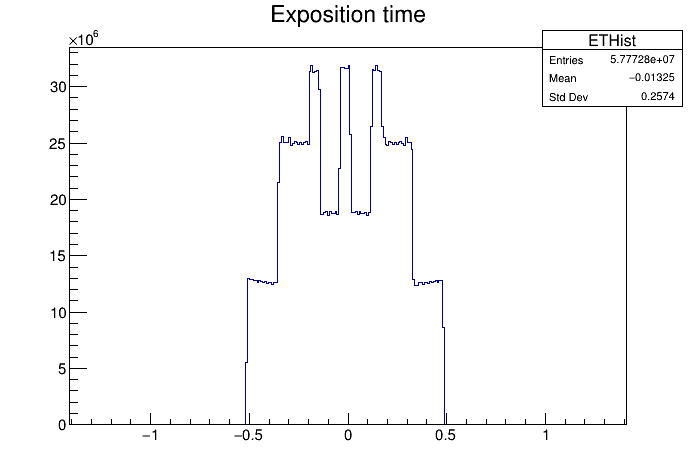

In [14]:
ETC = ROOT.TCanvas()
ETHist.Draw('HIST')
ETC.Draw()

In [15]:
ALPIDE_norm=np.zeros(ETHist.GetNbinsX()+1)

for i in range(ETHist.GetNbinsX()+1):
    ALPIDE_norm[i]=ETHist.GetBinContent(i)

## Analysis with normalization (time and Strobe parameters)

In [16]:
DATA_PATH = "Data"
DATA_NAME = "center_alpide"

Run_Analysis   = True
Force_Analysis = False

### Load files of a cartain dataset

In [17]:
files=os.listdir(DATA_PATH + "/")

with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        pbar.update(1)

        if name.startswith(DATA_NAME):
            angle = int(name.split('_')[2])*(1 if name.split('_')[3]=='DC' else -1)
            
            root_file = Path("Analyzed_Data/"+name+"/"+name+".root")
            root_file_existence_flag = root_file.is_file()

            if (Run_Analysis and not root_file_existence_flag) or Force_Analysis:
                Args = "-Df "+DATA_PATH+" -f "+name+" -p -A DB -NThr "+N_Threads+" -d 3 15 -s %i"%(angle)
                %run 'Packet_analyzer_test.py' {Args}

100%|██████████| 374/374 [00:00<00:00, 204333.68it/s]


### Merge all `TTree`s

In [18]:
! $ROOTSYS/bin/hadd -f Tot_data_tree/Tot_center_3SC_37DC_test.root Analyzed_Data/center_alpide*/*.root

hadd Target file: Tot_data_tree/Tot_center_3SC_37DC_test.root
hadd compression setting for all output: 1
hadd Source file 1: Analyzed_Data/center_alpide_17_DC_5m_run10_170121/center_alpide_17_DC_5m_run10_170121.root
hadd Source file 2: Analyzed_Data/center_alpide_17_DC_5m_run11_170121/center_alpide_17_DC_5m_run11_170121.root
hadd Source file 3: Analyzed_Data/center_alpide_17_DC_5m_run12_170121/center_alpide_17_DC_5m_run12_170121.root
hadd Source file 4: Analyzed_Data/center_alpide_17_DC_5m_run13_170121/center_alpide_17_DC_5m_run13_170121.root
hadd Source file 5: Analyzed_Data/center_alpide_17_DC_5m_run14_170121/center_alpide_17_DC_5m_run14_170121.root
hadd Source file 6: Analyzed_Data/center_alpide_17_DC_5m_run15_170121/center_alpide_17_DC_5m_run15_170121.root
hadd Source file 7: Analyzed_Data/center_alpide_17_DC_5m_run16_170121/center_alpide_17_DC_5m_run16_170121.root
hadd Source file 8: Analyzed_Data/center_alpide_17_DC_5m_run17_170121/center_alpide_17_DC_5m_run17_170121.root
hadd So

### Convert the merged `TTree` in numpy arrays

In [19]:
root_file_1  = ROOT.TFile.Open("Tot_data_tree/Tot_center_3SC_37DC_test.root")
Data_tree    = root_file_1.Get("tree")

Noise_points = Data_tree.AsMatrix(['Rnoise'])
Areas        = Data_tree.AsMatrix(['Rareas'])
Means        = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Theta        = Data_tree.AsMatrix(['Rtheta'])
#Weight       = Data_tree.AsMatrix(['Rweight'])
Exptime      = Data_tree.AsMatrix(['Reetime'])
Ratios       = Data_tree.AsMatrix(['Rratios'])

### Plot hitmap

501.1161154341241 257.38806256086446


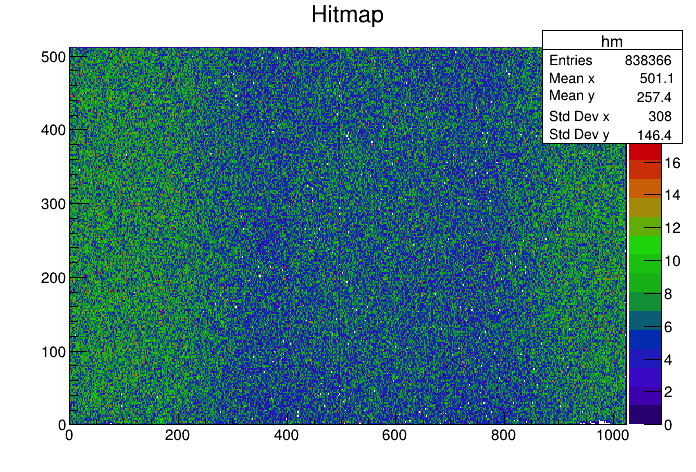

In [20]:
hm = ROOT.TH2D('hm','Hitmap',512,0,1024,256,0,512)

for coordinate in Means:
    hm.Fill(coordinate[0],coordinate[1])
    
ROOT.gStyle.SetPalette(107)
    
HC = ROOT.TCanvas()
hm.Draw('COLZ')
HC.Draw()

print(np.mean(Means[:,0]), np.mean(Means[:,1]))

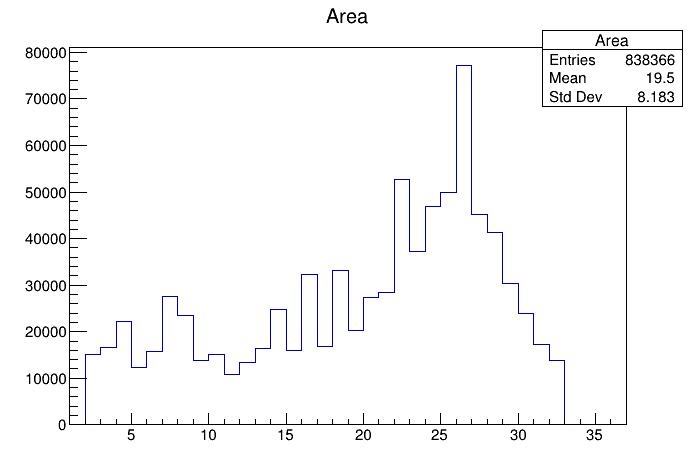

In [21]:
ar_max = int(np.amax(Areas))
ar_max = 37
nbins  = int((ar_max-1))

ArHist, AC = make_histo(Areas, 'Area', nbins, 1, ar_max)
AC.Draw()

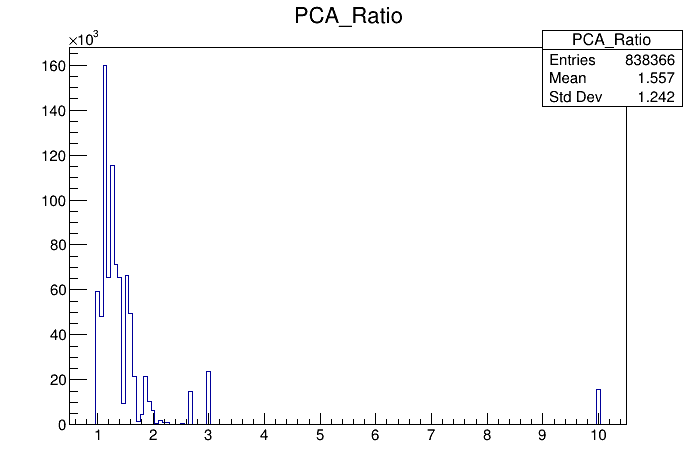

In [22]:
r_max = (np.amax(Ratios) + 0.5)
nbins = 150

RHist, RC = make_histo(Ratios,'PCA_Ratio', nbins, 0.5, r_max)
RC.Draw()

In [23]:
Area_thr  = 13
Ratio_thr = 3.21

mask_thr =  np.logical_and (np.squeeze(Areas)      > Area_thr, np.squeeze(Ratios)     < Ratio_thr)
mask_x   =  np.logical_and (np.squeeze(Means[:,0]) > xmin    , np.squeeze(Means[:,0]) < xmax     )
mask_y   =  np.logical_and (np.squeeze(Means[:,1]) > ymin    , np.squeeze(Means[:,1]) < ymax     )

mask = np.logical_and(mask_thr, np.logical_and(mask_x, mask_y))


Areas_disc  = Areas [mask]
Means_disc  = Means [mask]
Theta_disc  = Theta [mask]
#Weight_disc = Weight[mask]
Exptime_disc= Exptime[mask]
Ratios_disc = Ratios[mask]

## Find profile center

In [24]:
alpide_data   = []
alpide_weight = []

for value in Theta_disc:
    alpide_data.append(value * 180/np.pi)
    alpide_weight.append(1 / ALPIDE_norm[int((thbins+1)*(value)/(th_max-th_min)+thbins/2)+1])
    
alpide_data   = np.array(alpide_data  )
alpide_weight = np.array(alpide_weight)
    
n, bins, patches = plt.hist(alpide_data, weights=alpide_weight, bins=500, density=True, label="data")
plt.close()

mask_center = np.logical_and (bins      >= -4, bins <= 4)
bins_center = bins[mask_center]
n_center    = n[mask_center[:-1]]

half_bin   = (bins_center[1] - bins_center[0]) / 2
popt, pcov = curve_fit(parabola, bins_center+half_bin, n_center)
center     = -popt[1] / (2*popt[0])

print('Profile center=%1.3f°' % center)

alpide_data_centered = alpide_data - center

Profile center=0.392°


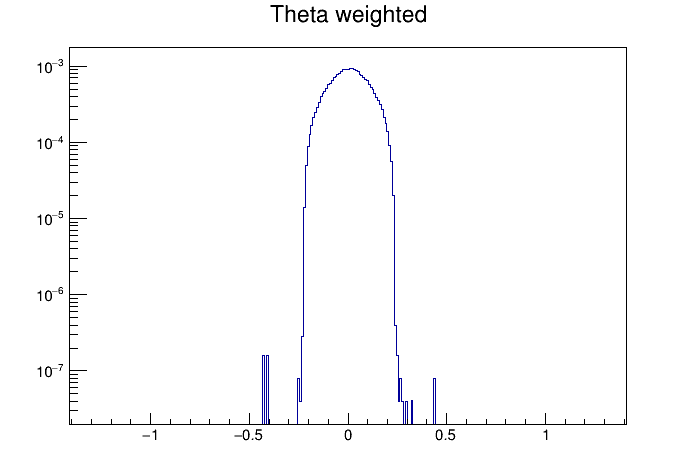

In [25]:
ThHist = ROOT.TH1F('ThHist', 'Theta weighted',thbins,th_min,th_max)


for value in Theta_disc:
    ThHist.Fill(value)
    
ThHist.Divide(ThHist,ETHist)
    
ThHist.SetStats(False)
    
TC = ROOT.TCanvas()

ThHist.Draw('HIST')
TC.SetLogy()
TC.Draw()

Warning in <TFile::Append>: Replacing existing TH1: ThHist (Potential memory leak).


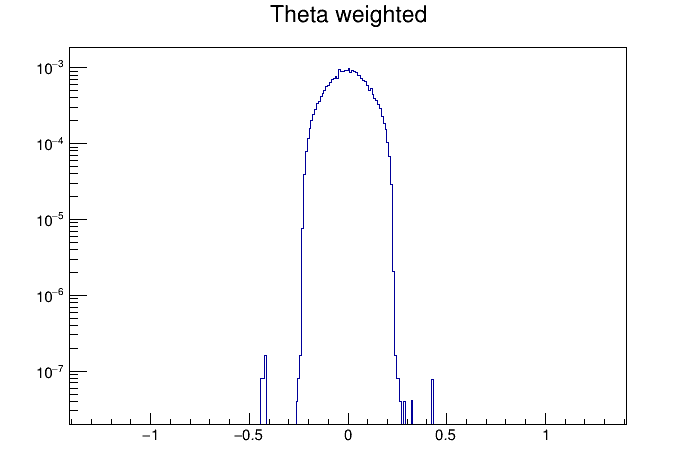

In [26]:
nbins  = 300

ThHist = ROOT.TH1F('ThHist', 'Theta weighted', nbins, th_min, th_max)

for value in Theta_disc:
    ThHist.Fill(value-center * np.pi/180, 1/(ALPIDE_norm[int((thbins+1)*(value)/(th_max-th_min)+thbins/2)+1]))
    
ThHist.SetStats(False)
    
TC = ROOT.TCanvas()

ThHist.Draw('HIST')
TC.SetLogy()
TC.Draw()

Warning in <TFile::Append>: Replacing existing TH1: Area (Potential memory leak).


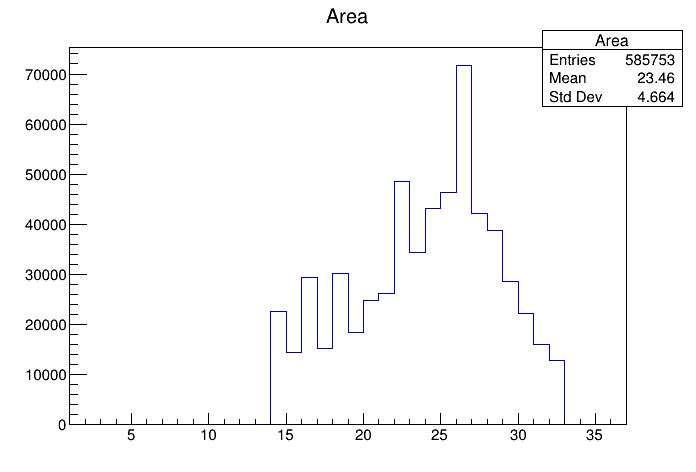

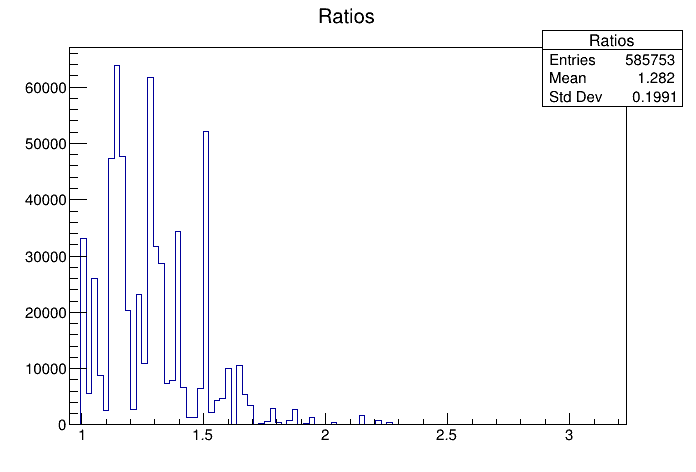

In [27]:
ar_max = int(np.amax(Areas_disc))
nbins  = int(ar_max)

ArHist,AC = make_histo(Areas_disc, 'Area', nbins, 1, ar_max+1)
AC.Draw()

r_max   = np.amax(Ratios_disc)
nbins   = 100

RHist, RC = make_histo(Ratios_disc, 'Ratios', nbins, 0.95, r_max+0.05)
RHist.Draw()
RC.Draw()

## Comparison with simulation

In [28]:
x_mean = np.average(np.ndarray.flatten(alpide_data), weights= alpide_weight)
x_mean

0.34989289170932153

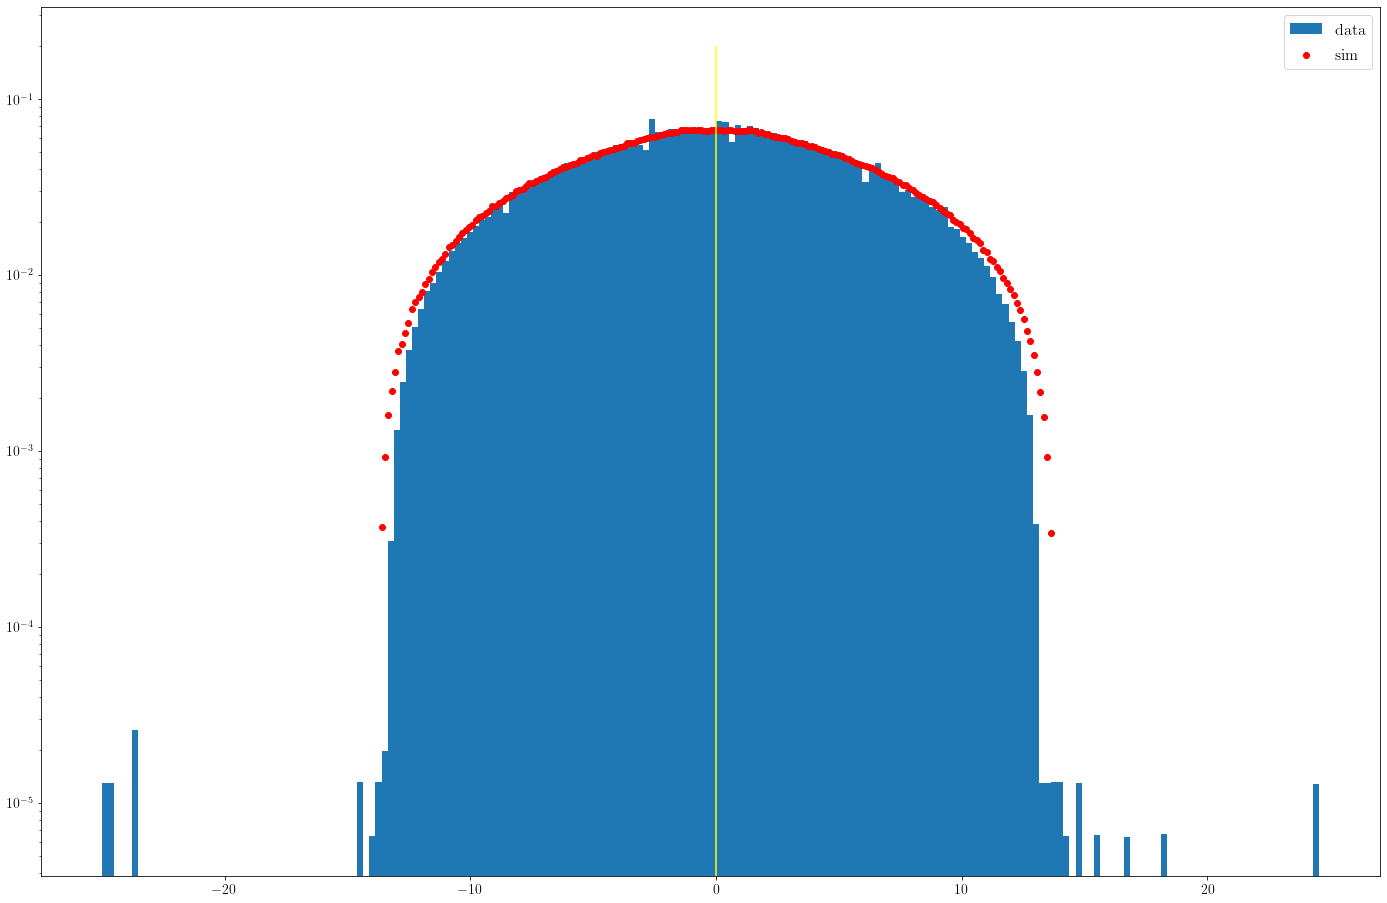

In [29]:
alpide_sim = np.loadtxt("../../../simulations/notebook/ALPIDE_beam_profile.txt")
alpide_sim = alpide_sim[np.logical_and(alpide_sim[:,0]>min(alpide_data_centered),alpide_sim[:,0]<max(alpide_data_centered))]

norm = np.sum(alpide_sim) * (alpide_sim[1,0]-alpide_sim[0,0])

plt.figure(figsize=(24,16))
plt.hist(alpide_data_centered, weights=alpide_weight, bins=len(alpide_sim), density=True, label="data")
plt.scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
plt.vlines(0,0,0.2, color='yellow', zorder=10000)
plt.yscale("log")
plt.legend()

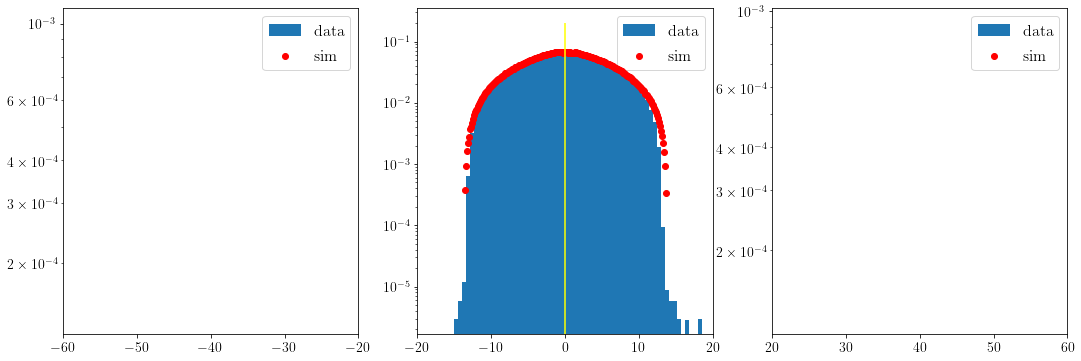

In [30]:
fig, axs = plt.subplots(1,3, figsize=(18, 6))


axs[0].hist(alpide_data_centered, weights=alpide_weight, bins=90, density=True, label="data")
axs[0].scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
axs[0].set_xlim(-60,-20)
axs[0].set_ylim(alpide_sim[np.argmin(abs(-60-alpide_sim[:,0])), 1]/3/norm,
                alpide_sim[np.argmin(abs(-20-alpide_sim[:,0])), 1]*3/norm)
axs[0].set_yscale("log")
axs[0].legend()

axs[1].hist(alpide_data_centered, weights=alpide_weight, bins=90, density=True, label="data")
axs[1].scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
axs[1].vlines(0,0,0.2, color='yellow', zorder=10000)
axs[1].set_xlim(-20,20)
axs[1].set_yscale("log")
axs[1].legend()

axs[2].hist(alpide_data_centered, weights=alpide_weight, bins=90, density=True, label="data")
axs[2].scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
axs[2].set_xlim(20,60)
axs[2].set_ylim(alpide_sim[np.argmin(abs(60-alpide_sim[:,0])), 1]/3/norm,
                alpide_sim[np.argmin(abs(20-alpide_sim[:,0])), 1]*3/norm)
axs[2].set_yscale("log")
axs[2].legend()

## X-Y area mapping

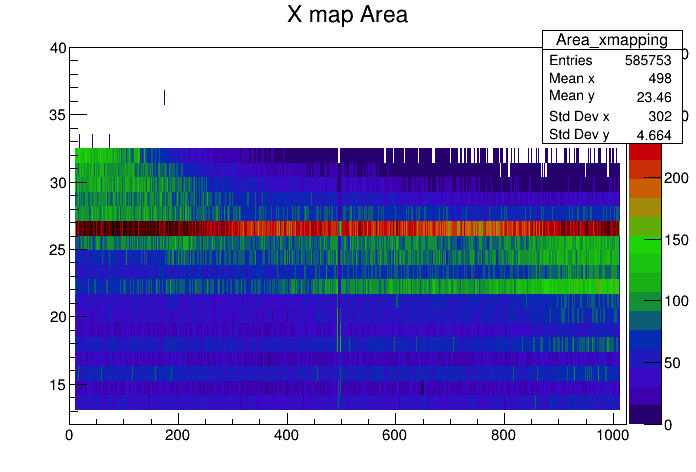

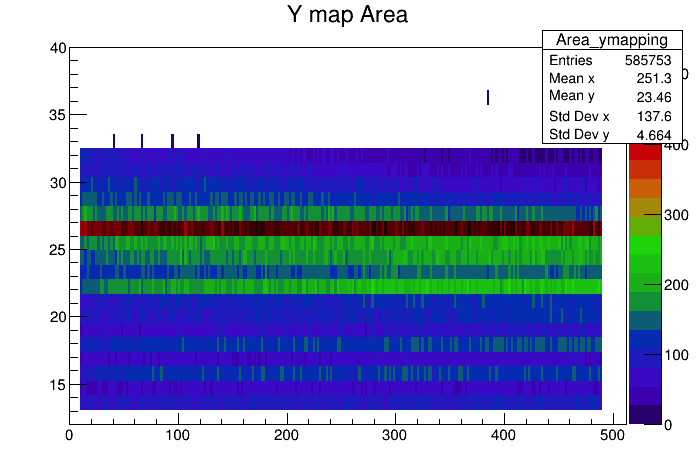

In [31]:
Area_nbins = 40-Area_thr-1

Area_xmapping = ROOT.TH2D('Area_xmapping','X map Area',512,0,1024,Area_nbins,Area_thr-1,40)

for coordinate,Area in zip(Means_disc,Areas_disc):
    Area_xmapping.Fill(coordinate[0],Area)
    
ROOT.gStyle.SetPalette(107)
    
HAXM = ROOT.TCanvas()
Area_xmapping.Draw('COLZ')
HAXM.Draw()

Area_ymapping = ROOT.TH2D('Area_ymapping', 'Y map Area', 256, 0, 512, Area_nbins, Area_thr-1, 40)

for coordinate,Area in zip(Means_disc, Areas_disc):
    Area_ymapping.Fill(coordinate[1], Area)
    
ROOT.gStyle.SetPalette(107)
    
HAYM = ROOT.TCanvas()
Area_ymapping.Draw('COLZ')
HAYM.Draw()

## Theta area mapping

<ipython-input-32-8039e6c2c741>:19: RuntimeWarning: divide by zero encountered in double_scalars
  Area_thmapping_nd.Fill(value*180/np.pi-center,Area,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))


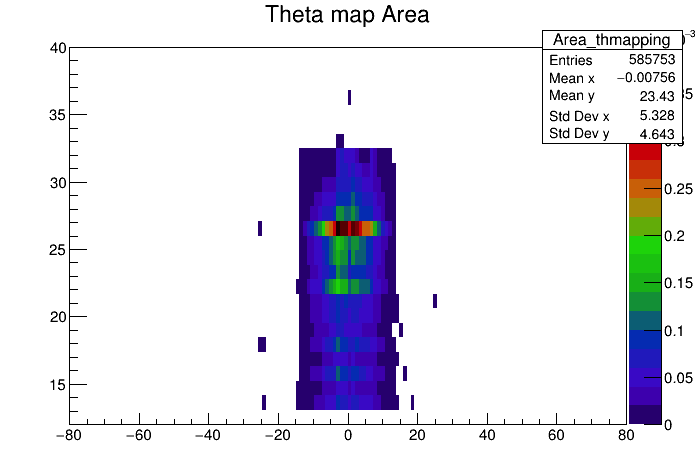

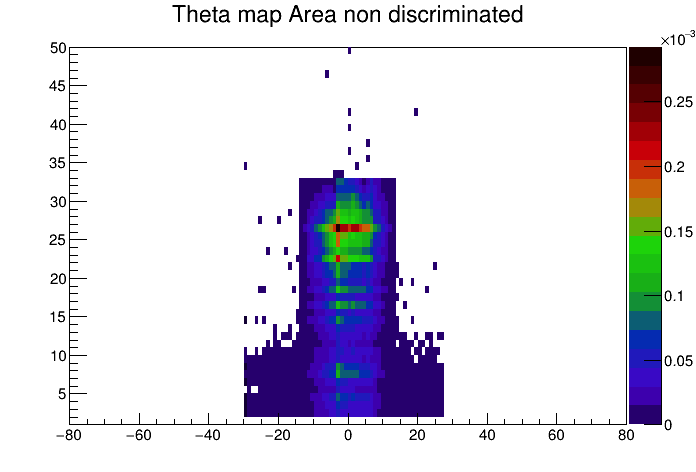

In [32]:
Area_nbins  = 40-Area_thr-1
nbins_theta = 150

Area_thmapping = ROOT.TH2D('Area_thmapping', 'Theta map Area', nbins_theta, -80, 80, Area_nbins, Area_thr-1, 40)

for value,Area in zip(Theta_disc, Areas_disc):
    Area_thmapping.Fill(value*180/np.pi-center, Area, 1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
    
HATHM=ROOT.TCanvas()
Area_thmapping.Draw('COLZ')
#HATHM.SetLogz()
HATHM.Draw()

Area_thmapping_nd = ROOT.TH2D('Area_thmapping_nd','Theta map Area non discriminated',nbins_theta,-80,80,49,1,50)

for value,Area in zip(Theta,Areas):
    Area_thmapping_nd.Fill(value*180/np.pi-center,Area,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
Area_thmapping_nd.SetStats(False)
    
HATHMND = ROOT.TCanvas()
Area_thmapping_nd.Draw('COLZ')
HATHMND.Draw()

<ipython-input-33-ede5ca6b93f1>:18: RuntimeWarning: divide by zero encountered in double_scalars
  PCAr_thmapping_nd.Fill(value*180/np.pi-center,PCAr,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))


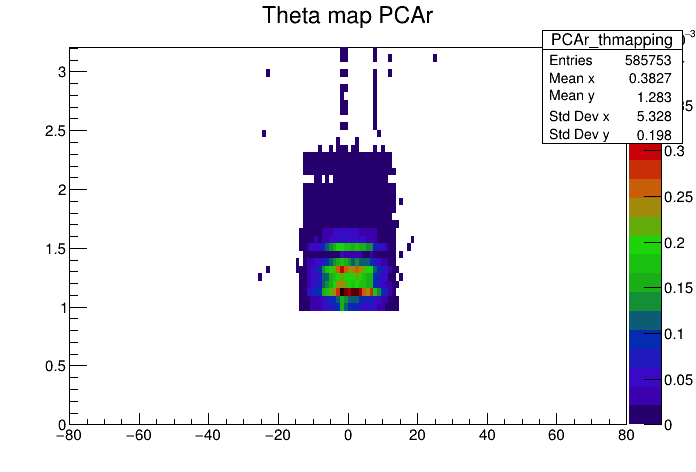

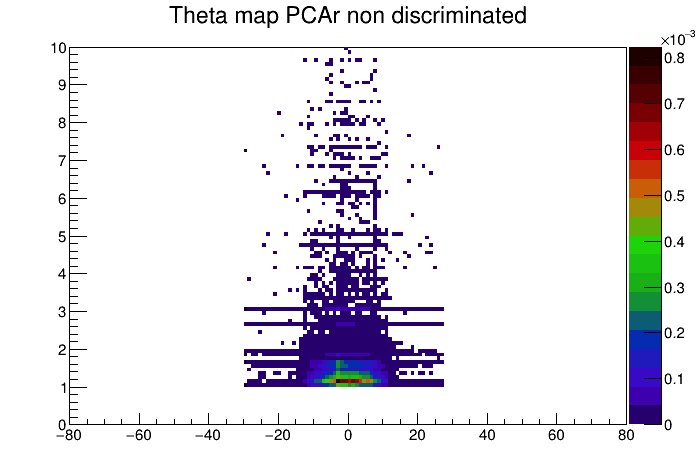

In [33]:
PCAr_nbins=50
nbins_theta=150

PCAr_thmapping = ROOT.TH2D('PCAr_thmapping','Theta map PCAr',nbins_theta,-80,80,PCAr_nbins,0,Ratio_thr)

for value,PCAr in zip(Theta_disc,Ratios_disc):
    PCAr_thmapping.Fill(value*180/np.pi-center/180,PCAr,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
    
HPrTHM=ROOT.TCanvas()
PCAr_thmapping.Draw('COLZ')
HPrTHM.Draw()

PCAr_thmapping_nd = ROOT.TH2D('PCAr_thmapping_nd','Theta map PCAr non discriminated',nbins_theta,-80,80,2*PCAr_nbins,0,10)

for value,PCAr in zip(Theta,Ratios):
    PCAr_thmapping_nd.Fill(value*180/np.pi-center,PCAr,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
PCAr_thmapping_nd.SetStats(False)
    
HPrTHMND=ROOT.TCanvas()
PCAr_thmapping_nd.Draw('COLZ')
#HPrTHMND.SetLogz()
HPrTHMND.Draw()

## THR analysis
* Noise vs VCASN
* Area vs PCA ratio 2D Histo

In [34]:
#Run packet analyzer script for all threshold
Data_folder_path="Data"
files=os.listdir(Data_folder_path+"/")
for name in files:
    if name.startswith('Data_VCASN_'):
        #analyze the data
        args = "-f "+name+" -Df "+Data_folder_path+" -d 1 10 "
        %run 'Packet_analyzer.py' {args}

Data_VCASN_31: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


In [35]:
#Noise dependace on VCASN

VCASN_val    = []
Noise_points = []


files=os.listdir(Data_folder_path+"/")
for name in files:
    if name.startswith('Data_VCASN_'):
        V_CASN_THR=int(name.split('_')[2], base=16)
        VCASN_val = np.append(VCASN_val,V_CASN_THR)
        
        file=open("Data/"+name+"/Stat_"+name+".txt")
        line=file.readlines()
        for l in line:
            if (l.startswith("Readout_time")):
                time=float(l.split('=')[1].strip()[:-1])
            if (l.startswith("Strobe")):
                Strobe=int(l.split('=')[1].strip()[:-1])
            if (l.startswith("Gap")):
                Gap=int(l.split('=')[1].strip()[:-1])
        
        filename="Analyzed_Data/"+name+"/"+name+".root"
        root_file_1  = ROOT.TFile.Open(filename)
        Data_tree    = root_file_1.Get("tree")
        Noise        = Data_tree.AsMatrix(['Rnoise'])
        Noise_points = np.append(Noise_points,Noise[0]*(Strobe+Gap)/(time*Strobe))
        

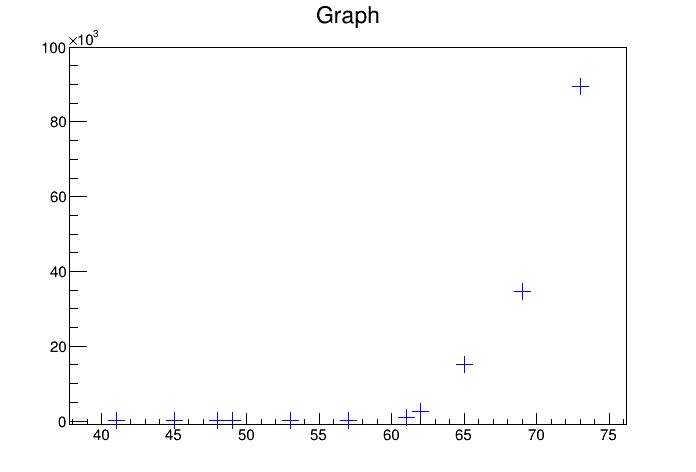

In [36]:
#plt.plot(VCASN_val,Noise_points, 'bo')
Noise_graph = ROOT.TGraph(len(Noise_points),VCASN_val,Noise_points)

Noise_graph.SetMarkerColor(4)
Noise_graph.SetMarkerStyle(2)
Noise_graph.SetMarkerSize(2)
YAxis = Noise_graph.GetYaxis()
YAxis.SetRangeUser(-1000,100000)

NPC = ROOT.TCanvas()

Noise_graph.Draw('AP')
NPC.Draw()

In [37]:
#convert the TTree in np arrays
name        = "gold_alpide_27_DC_5m_run4_090121"
filename    = "Analyzed_Data/"+name+"/"+name+".root"
root_file = ROOT.TFile.Open(filename)
Data_tree   = root_file.Get("tree")

Areas_AxP  = Data_tree.AsMatrix(['Rareas'])
Means_AxP  = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Ratios_AxP = Data_tree.AsMatrix(['Rratios'])

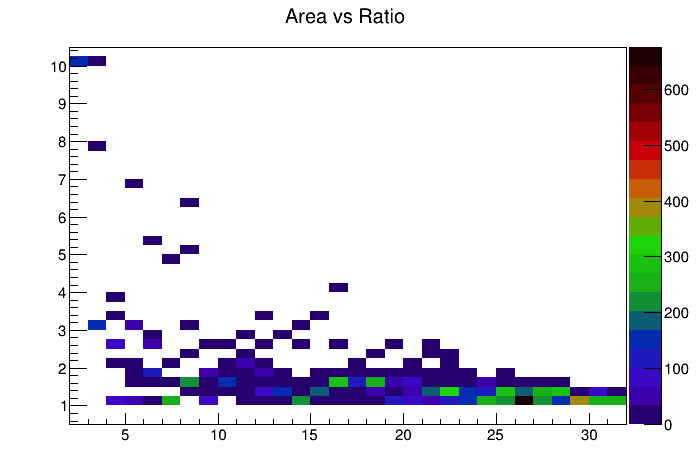

In [38]:
ar_max=int(np.amax(Areas_AxP))
A_R_Histo = ROOT.TH2D('A_R_Histo','Area vs Ratio',ar_max-2,2,ar_max,40,0.5,10.5)

for i in range(len(Areas_AxP)):
    A_R_Histo.Fill(Areas_AxP[i],Ratios_AxP[i])
    
    
ARC=ROOT.TCanvas()
A_R_Histo.Draw("COLZ")
A_R_Histo.SetStats(False)
ARC.Draw()